In [1]:
import os
import re
import cv2
import json
import array
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import OpenEXR
import Imath
from mpl_toolkits.mplot3d import Axes3D
from scipy import ndimage

In [14]:
pano_dir = "/hpc2hdd/home/yhuang489/ylguo/PanoData/area_3/area_3/pano/rgb"
xyz_dir = "/hpc2hdd/home/yhuang489/ylguo/PanoData/area_3/area_3/pano/global_xyz"

In [28]:
pano_list = os.listdir(pano_dir)
print(len(pano_list))
pano_name = pano_list[34]
print(pano_name)
pano_path = os.path.join(pano_dir, pano_name)
xyz_name = pano_name.replace('rgb.png', 'global_xyz.exr')
xyz_path = os.path.join(xyz_dir, xyz_name)

86
camera_505548017eed4d4da09b369be5ecb160_lounge_2_frame_equirectangular_domain_rgb.png


## 检查全景图像

(2048, 4096, 4)


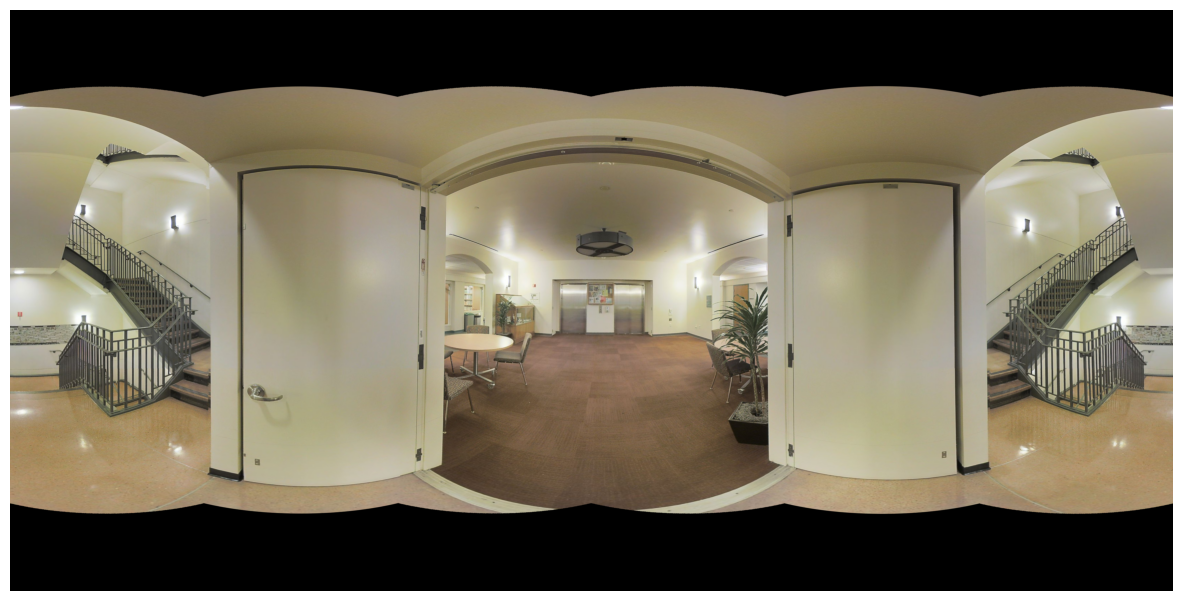

In [29]:
pano = Image.open(pano_path)
np_pano = np.array(pano)
print(np_pano.shape)
fig, axis = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))
axis.imshow(np_pano)
axis.axis('off')
plt.show()

## 检查3D标注

In [32]:
# 读取exr文件
def read_exr( image_fpath ):
    """ Reads an openEXR file into an RGB matrix with floats """
    f = OpenEXR.InputFile( image_fpath )
    dw = f.header()['dataWindow']
    w, h = (dw.max.x - dw.min.x + 1, dw.max.y - dw.min.y + 1)    
    im = np.empty( (h, w, 3) )

    # Read in the EXR
    FLOAT = Imath.PixelType(Imath.PixelType.FLOAT)
    channels = f.channels( ["R", "G", "B"], FLOAT )
    for i, channel in enumerate( channels ):
        im[:,:,i] = np.reshape( array.array( 'f', channel ), (h, w) )
    return im

# 可视化3D场景
def plot_xyz_pointcloud(xyz_map, step=10):
    h, w, _ = xyz_map.shape
    pts = xyz_map[::step, ::step].reshape(-1, 3)  # 降采样
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(pts[:, 0], pts[:, 1], pts[:, 2], s=1, c=pts[:, 2], cmap='viridis')
    ax.set_title("3D Point Cloud from Global XYZ")
    ax.set_xlabel("X (m)")
    ax.set_ylabel("Y (m)")
    ax.set_zlabel("Z (m)")
    plt.show()

(2048, 4096, 3)


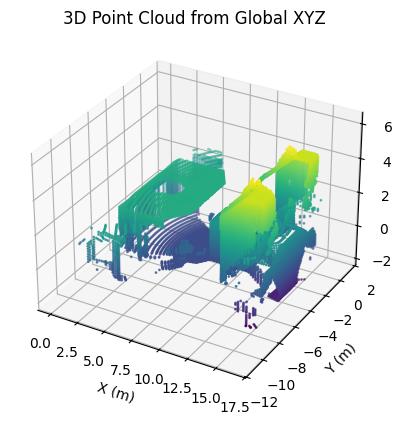

In [33]:
xyz_image = read_exr(xyz_path)
print(xyz_image.shape)
plot_xyz_pointcloud(xyz_image)

## 检查实例分割标注

In [48]:
""" Label functions """
def load_labels( label_file ):
    """ Convenience function for loading JSON labels """
    with open( label_file ) as f:
        return json.load( f )

def parse_label( label ):
    """ Parses a label into a dict """
    res = {}
    clazz, instance_num, room_type, room_num, area_num = label.split( "_" )
    res[ 'instance_class' ] = clazz
    res[ 'instance_num' ] = int( instance_num )
    res[ 'room_type' ] = room_type
    res[ 'room_num' ] = int( room_num )
    res[ 'area_num' ] = int( area_num )
    return res

def get_index(color):
    """ Parse a color as a base-256 number and return the index """
    r, g, b = map(int, color)  # 👈 转换为 Python int 类型，避免 uint8 溢出
    return r * 256 * 256 + g * 256 + b

In [2]:
instance_dir = "/hpc2hdd/home/yhuang489/ylguo/PanoData/area_3/area_3/pano/semantic"
instance_name = pano_name.replace('rgb', 'semantic')
instance_path = os.path.join(instance_dir, instance_name)
semantic_label_path = "/hpc2hdd/home/yhuang489/ylguo/PanoCode/2D-3D-Semantics/assets/semantic_labels.json"

NameError: name 'pano_name' is not defined

In [43]:
instance_image = Image.open(instance_path)
np_instance_image = np.array(instance_image)
print(np_instance_image.shape)
print(np_instance_image[201, 201])

(2048, 4096, 3)
[  0   3 163]


In [55]:
# 加载标签
semantic_labels = load_labels(semantic_label_path)
print(len(semantic_labels))

9816


In [61]:
instance_index = np.zeros([2048, 4096])
for i in range(2048):
    for j in range(4096):
        instance_index[i, j] = get_index(np_instance_image[i, j])
instance_ids = np.unique(instance_index)
# print(instance_ids)
instance_ids = instance_ids[instance_ids < 9816]

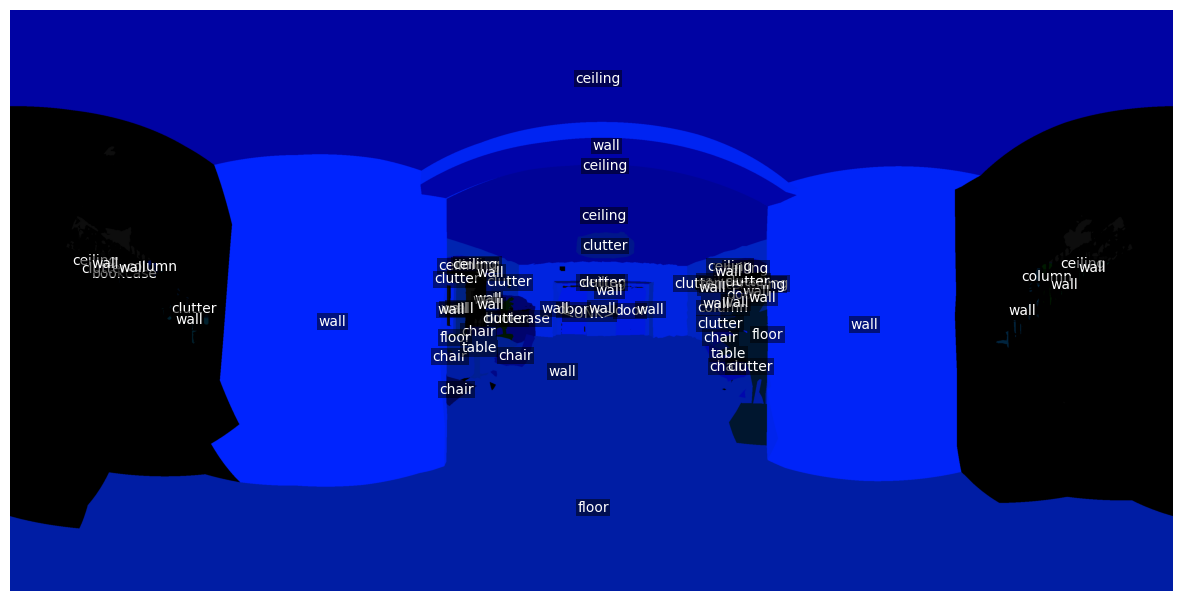

In [62]:
fig, axis = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))
axis.imshow(np_instance_image)
axis.axis('off')
# 为每个实例标注文本
for inst_id in instance_ids:
    # 在标签中寻找这个inst_id对应的实例类别
    label = parse_label(semantic_labels[int(inst_id)])
    mask = (instance_index == inst_id).astype(np.uint8)

    # 计算该实例的质心
    cy, cx = ndimage.center_of_mass(mask)
    plt.text(cx, cy, str(label['instance_class']),
             fontsize=10, color='white', ha='center', va='center',
             bbox=dict(facecolor='black', edgecolor='none', pad=1, alpha=0.5))
plt.show()

## 生成数据测试